# **<center><font style="color:rgb(100,109,254)">Playing Subway Surfers Game using Pose Detection</font> </center>**


<img src='https://drive.google.com/uc?export=download&id=1Msiu4noiq5NKViqXX8TE-6sei6ycS1Xx'>

<img src='https://drive.google.com/uc?export=download&id=1bREfnsfCWjVyMRjXM0kI0V33kRQ7f_dY'>

In [1]:
%pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install pyautogui

Note: you may need to restart the kernel to use updated packages.


## **<font style="color:rgb(134,19,348)"> Outline </font>**

- ***`Step 1:`* Perform Pose Detection**

- ***`Step 2:`* Control Starting Mechanism**

- ***`Step 3:`* Control Horizontal Movements**

- ***`Step 4:`* Control Vertical Movements**

- ***`Step 5:`* Control Keyboard and Mouse with PyautoGUI**

- ***`Step 6:`* Build the Final Application**

Alright, let's get started.

### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

We will start by importing the required libraries.

In [3]:
import cv2
import pyautogui
from time import time
from math import hypot
import mediapipe as mp
import matplotlib.pyplot as plt

### **<font style="color:rgb(134,19,348)">Initialize the Pose Detection Model</font>**

After that we will need to initialize the **`mp.solutions.pose`** class and then call the **`mp.solutions.pose.Pose()`** function  with appropriate arguments and also initialize **`mp.solutions.drawing_utils`** class that is needed to visualize the landmarks after detection.

In [4]:
# Initialize mediapipe pose class.
mp_pose = mp.solutions.pose

# Setup the Pose function for images.
pose_image = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=1)

# Setup the Pose function for videos.
pose_video = mp_pose.Pose(static_image_mode=False, model_complexity=1, min_detection_confidence=0.7,
                          min_tracking_confidence=0.7)

# Initialize mediapipe drawing class.
mp_drawing = mp.solutions.drawing_utils 

## **<font style="color:rgb(134,19,348)">Step 1: Perform Pose Detection</font>**

To implement the game control mechanisms, we will need the current pose info of the person controlling the game, as our intention is to control the character with the movement of the person in the frame. We want the game's character to move left, right, jump and crouch with the identical movements of the person.

So we will create a function **`detectPose()`** that will take an image as input and perform pose detection on the person in the image using the mediapipe's pose detection solution to get **thirty-three 3D landmarks** on the body and the function will display the results or return them depending upon the passed arguments.

<img src="https://drive.google.com/uc?export=download&id=1CDO0KiXZEOuWc7xLEm7EFLLQf2hydCoI">

This function is quite similar to the one we had created in the previous post. The only difference is that we are not plotting the pose landmarks in 3D and we are passing a few more optional arguments to the function **`mp.solutions.drawing_utils.draw_landmarks()`** to specify the drawing style.

You probably do not want to lose control of the game's character whenever some other person comes into the frame (and starts controlling the character), so that annoying scenario is already taken care of, as the solution we are using only detects the landmarks of the most prominent person in the image.

So you do not need to worry about losing control as long as you are the most prominent person in the frame as it will automatically ignore the people in the background.

In [5]:
def detectPose(image, pose, draw=False, display=False):
    '''
    This function performs the pose detection on the most prominent person in an image.
    Args:
        image:   The input image with a prominent person whose pose landmarks needs to be detected.
        pose:    The pose function required to perform the pose detection.
        draw:    A boolean value that is if set to true the function draw pose landmarks on the output image. 
        display: A boolean value that is if set to true the function displays the original input image, and the 
                 resultant image and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn if it was specified.
        results:      The output of the pose landmarks detection on the input image.
    '''
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Check if any landmarks are detected and are specified to be drawn.
    if results.pose_landmarks and draw:
    
        # Draw Pose Landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS,
                                  landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255),
                                                                               thickness=3, circle_radius=3),
                                  connection_drawing_spec=mp_drawing.DrawingSpec(color=(49,125,237),
                                                                               thickness=2, circle_radius=2))

    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
    # Otherwise
    else:

        # Return the output image and the results of pose landmarks detection.
        return output_image, results

Now we will test the function **`detectPose()`** created above to perform pose detection on a sample image and display the results.

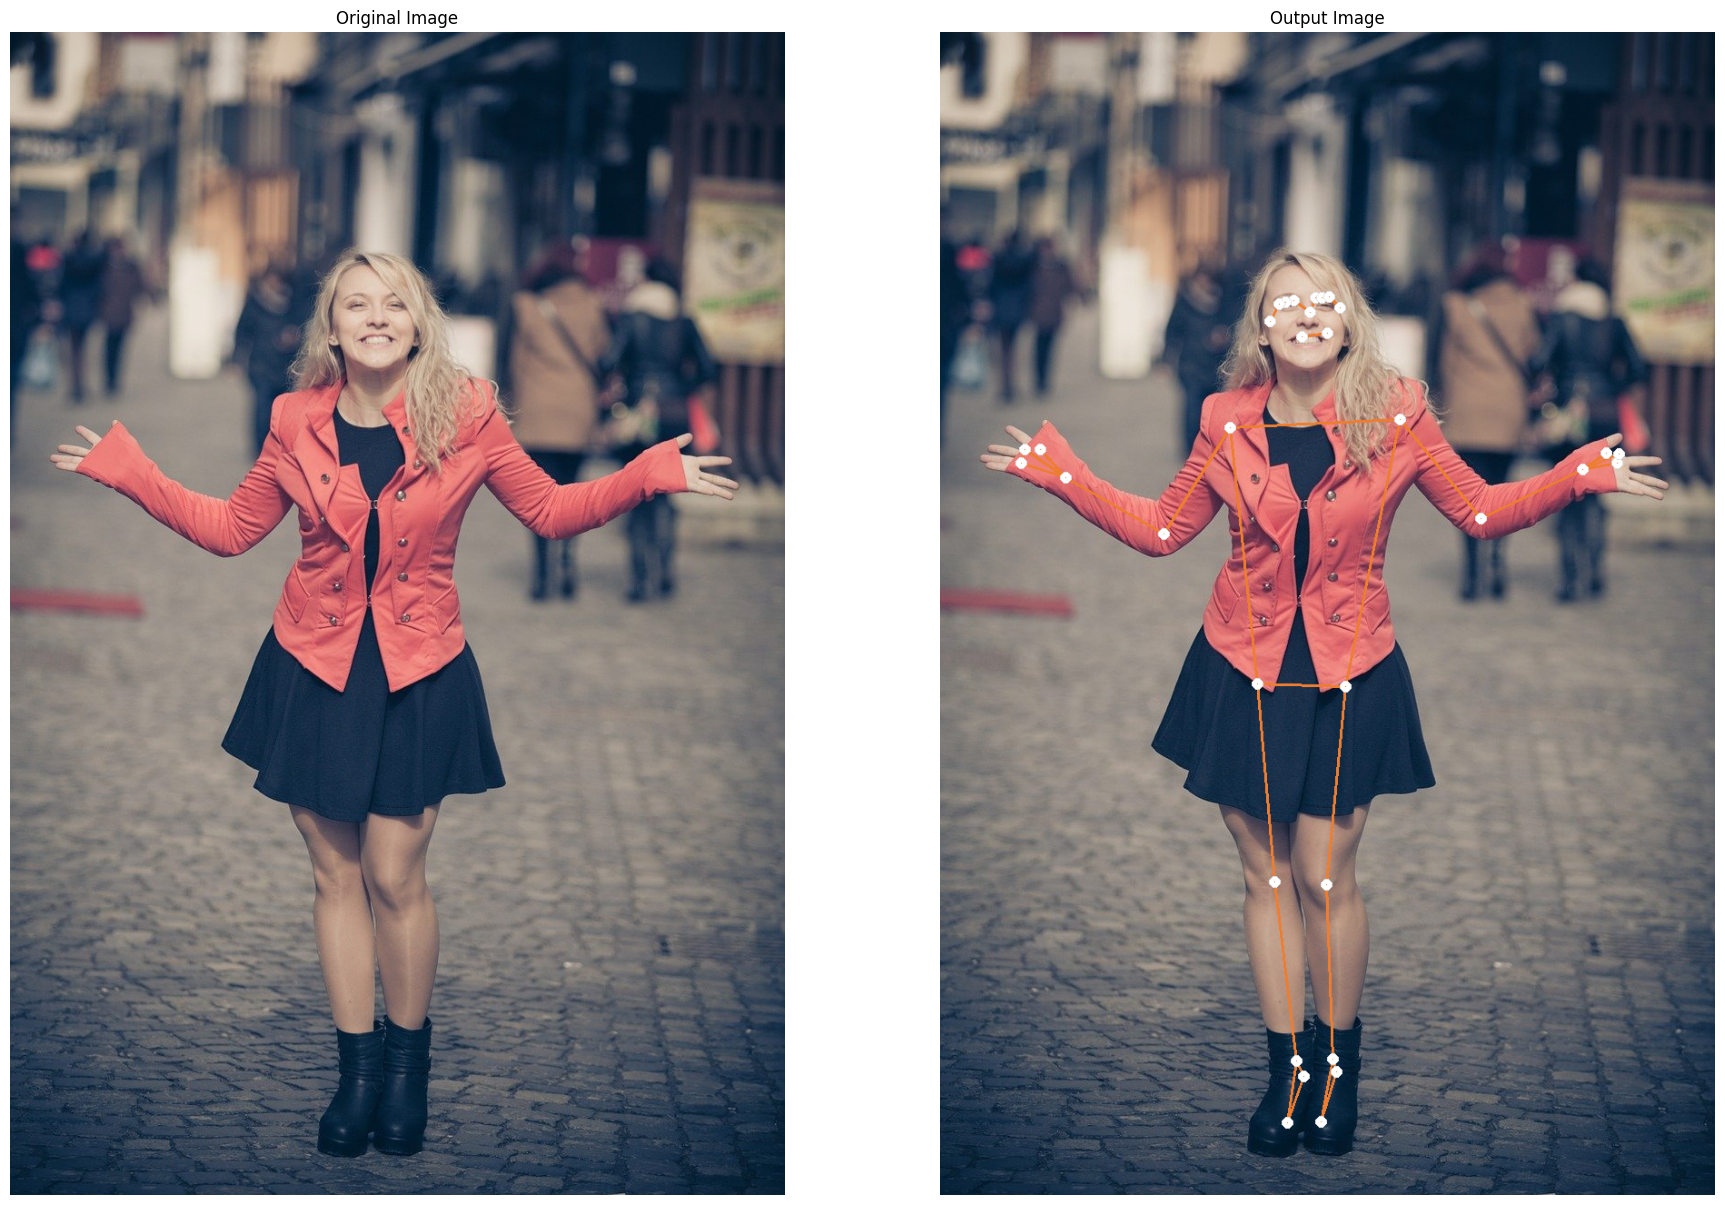

In [6]:
# Read a sample image and perform pose landmarks detection on it.
IMG_PATH = 'media/sample.jpg'
image = cv2.imread(IMG_PATH)
detectPose(image, pose_image, draw=True, display=True)

It worked pretty well! if you want you can test the function on other images too by just changing the value of the variable **`IMG_PATH`** in the cell above, it will work fine as long as there is a prominent person in the image.

## **<font style="color:rgb(134,19,348)">Step 2: Control Starting Mechanism</font>**

In this step, we will implement the game starting mechanism, what we want is to start the game whenever the most prominent person in the image/frame joins his both hands together. So we will create a function **`checkHandsJoined()`** that will check whether the hands of the person in an image are joined or not. 

The function **`checkHandsJoined()`** will take in the results of the pose detection returned by the function **`detectPose()`** and will use the **`LEFT_WRIST`** and **`RIGHT_WRIST`** landmarks coordinates from the list of thirty-three landmarks, to calculate the euclidean distance between the hands of the person.

<img src='https://drive.google.com/uc?export=download&id=1p76mydN2UXU_0lMpQD5pzyM01ec2PQDy' width=300>

And then utilize an appropriate threshold value to compare with and check whether the hands of the person in the image/frame are joined or not and will display or return the results depending upon the passed arguments.

In [7]:
def checkHandsJoined(image, results, draw=False, display=False):
    '''
    This function checks whether the hands of the person are joined or not in an image.
    Args:
        image:   The input image with a prominent person whose hands status (joined or not) needs to be classified.
        results: The output of the pose landmarks detection on the input image.
        draw:    A boolean value that is if set to true the function writes the hands status & distance on the output image. 
        display: A boolean value that is if set to true the function displays the resultant image and returns nothing.
    Returns:
        output_image: The same input image but with the classified hands status written, if it was specified.
        hand_status:  The classified status of the hands whether they are joined or not.
    '''
    
    # Get the height and width of the input image.
    height, width, _ = image.shape
    
    # Create a copy of the input image to write the hands status label on.
    output_image = image.copy()
    
    # Get the left wrist landmark x and y coordinates.
    left_wrist_landmark = (results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].x * width,
                          results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_WRIST].y * height)

    # Get the right wrist landmark x and y coordinates.
    right_wrist_landmark = (results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].x * width,
                           results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_WRIST].y * height)
    
    # Calculate the euclidean distance between the left and right wrist.
    euclidean_distance = int(hypot(left_wrist_landmark[0] - right_wrist_landmark[0],
                                   left_wrist_landmark[1] - right_wrist_landmark[1]))
    
    # Compare the distance between the wrists with a appropriate threshold to check if both hands are joined.
    if euclidean_distance < 130:
        
        # Set the hands status to joined.
        hand_status = 'Hands Joined'
        
        # Set the color value to green.
        color = (0, 255, 0)
        
    # Otherwise.    
    else:
        
        # Set the hands status to not joined.
        hand_status = 'Hands Not Joined'
        
        # Set the color value to red.
        color = (0, 0, 255)
        
    # Check if the Hands Joined status and hands distance are specified to be written on the output image.
    if draw:

        # Write the classified hands status on the image. 
        cv2.putText(output_image, hand_status, (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, color, 3)
        
        # Write the the distance between the wrists on the image. 
        cv2.putText(output_image, f'Distance: {euclidean_distance}', (10, 70),
                    cv2.FONT_HERSHEY_PLAIN, 2, color, 3)
        
    # Check if the output image is specified to be displayed.
    if display:

        # Display the output image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Otherwise
    else:
    
        # Return the output image and the classified hands status indicating whether the hands are joined or not.
        return output_image, hand_status

Now we will test the function **`checkHandsJoined()`** created above on a real-time webcam feed to check whether it is working as we had expected or not.

In [8]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Hands Joined?', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Perform the pose detection on the frame.
    frame, results = detectPose(frame, pose_video, draw=True)
    
    # Check if the pose landmarks in the frame are detected.
    if results.pose_landmarks:
            
        # Check if the left and right hands are joined.
        frame, _ = checkHandsJoined(frame, results, draw=True)
                
    # Display the frame.
    cv2.imshow('Hands Joined?', frame)
    
    # Wait for 1ms. If a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

Woah! I am stunned, the pose detection solution is best known for its speed which is reflecting in the results as the **`distance`** and the **`hands status`** are updating very fast and are also highly accurate.

## **<font style="color:rgb(134,19,348)">Step 3: Control Horizontal Movements</font>**

Now comes the implementation of the left and right movements control mechanism of the game's character, what we want to do is to make the game's character move left and right with the horizontal movements of the person in the image/frame.

So we will create a function **`checkLeftRight()`** that will take in the pose detection results returned by the function **`detectPose()`** and will use the x-coordinates of the **`RIGHT_SHOULDER`** and **`LEFT_SHOULDER`** landmarks to determine the horizontal position (**`Left`, `Right` or `Center`**) in the frame after comparing the landmarks with the x-coordinate of the center of the image. 

The function will visualize or return the resultant image and the horizontal position of the person depending upon the passed arguments.

<img src='https://drive.google.com/uc?export=download&id=1LhngpRrIJYMYIlKMnUep4YxdXMni3RvI'>

In [9]:
def checkLeftRight(image, results, draw=False, display=False):
    '''
    This function finds the horizontal position (left, center, right) of the person in an image.
    Args:
        image:   The input image with a prominent person whose the horizontal position needs to be found.
        results: The output of the pose landmarks detection on the input image.
        draw:    A boolean value that is if set to true the function writes the horizontal position on the output image. 
        display: A boolean value that is if set to true the function displays the resultant image and returns nothing.
    Returns:
        output_image:         The same input image but with the horizontal position written, if it was specified.
        horizontal_position:  The horizontal position (left, center, right) of the person in the input image.
    '''
    
    # Declare a variable to store the horizontal position (left, center, right) of the person.
    horizontal_position = None
    
    # Get the height and width of the image.
    height, width, _ = image.shape
    
    # Create a copy of the input image to write the horizontal position on.
    output_image = image.copy()
    
    # Retreive the x-coordinate of the left shoulder landmark.
    left_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].x * width)

    # Retreive the x-corrdinate of the right shoulder landmark.
    right_x = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].x * width)
    
    # Check if the person is at left that is when both shoulder landmarks x-corrdinates
    # are less than or equal to the x-corrdinate of the center of the image.
    if (right_x <= width//2 and left_x <= width//2):
        
        # Set the person's position to left.
        horizontal_position = 'Left'

    # Check if the person is at right that is when both shoulder landmarks x-corrdinates
    # are greater than or equal to the x-corrdinate of the center of the image.
    elif (right_x >= width//2 and left_x >= width//2):
        
        # Set the person's position to right.
        horizontal_position = 'Right'
    
    # Check if the person is at center that is when right shoulder landmark x-corrdinate is greater than or equal to
    # and left shoulder landmark x-corrdinate is less than or equal to the x-corrdinate of the center of the image.
    elif (right_x >= width//2 and left_x <= width//2):
        
        # Set the person's position to center.
        horizontal_position = 'Center'
        
    # Check if the person's horizontal position and a line at the center of the image is specified to be drawn.
    if draw:

        # Write the horizontal position of the person on the image. 
        cv2.putText(output_image, horizontal_position, (5, height - 10), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 3)
        
        # Draw a line at the center of the image.
        cv2.line(output_image, (width//2, 0), (width//2, height), (255, 255, 255), 2)
        
    # Check if the output image is specified to be displayed.
    if display:

        # Display the output image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Otherwise
    else:
    
        # Return the output image and the person's horizontal position.
        return output_image, horizontal_position

Now we will test the function **`checkLeftRight()`** created above on a real-time webcam feed and will visualize the results updating in real-time with the horizontal movements.

In [10]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Horizontal Movements', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Perform the pose detection on the frame.
    frame, results = detectPose(frame, pose_video, draw=True)
    
    # Check if the pose landmarks in the frame are detected.
    if results.pose_landmarks:
            
        # Check the horizontal position of the person in the frame.
        frame, _ = checkLeftRight(frame, results, draw=True)
                
    # Display the frame.
    cv2.imshow('Horizontal Movements', frame)
    
    # Wait for 1ms. If a a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

Cool! the speed and accuracy of this model never fail to impress me.

## **<font style="color:rgb(134,19,348)">Step 4: Control Vertical Movements</font>**

In this one, we will implement the jump and crouch control mechanism of the game's character, what we want is to make the game's character jump and crouch whenever the person in the image/frame jumps and crouches. 


So we will create a function **`checkJumpCrouch()`** that will check whether the posture of the person in an image is `Jumping`, `Crouching` or `Standing` by utilizing the results of pose detection by the function **`detectPose()`**.

The function **`checkJumpCrouch()`** will retrieve the **`RIGHT_SHOULDER`** and **`LEFT_SHOULDER`** landmarks from the list to calculate the y-coordinate of the midpoint of both shoulders and will determine the posture of the person by doing a comparison with an appropriate threshold value. 

The threshold (**`MID_Y`**) will be the approximate y-coordinate of the midpoint of both shoulders of the person while in standing posture. It will be calculated before starting the game in the **`Step 6:` Build the Final Application** and will be passed to the function **`checkJumpCrouch()`**. 

But the issue with this approach is that the midpoint of both shoulders of the person while in standing posture will not always be exactly same as it will vary when the person will move closer or further to the camera. 

To tackle this issue we will add and subtract a margin to the threshold to get an upper and lower bound as shown in the image below.

<img src='https://drive.google.com/uc?export=download&id=1fNAsoK964C4ASIkX6UXJNtvooZjlZNQT'>

In [11]:
def checkJumpCrouch(image, results, MID_Y=250, draw=False, display=False):
    '''
    This function checks the posture (Jumping, Crouching or Standing) of the person in an image.
    Args:
        image:   The input image with a prominent person whose the posture needs to be checked.
        results: The output of the pose landmarks detection on the input image.
        MID_Y:   The intial center y-coordinate of both shoulders landmarks of the person recorded during starting
                 the game. This will give the idea of the person's height when he is standing straight.
        draw:    A boolean value that is if set to true the function writes the posture on the output image. 
        display: A boolean value that is if set to true the function displays the resultant image and returns nothing.
    Returns:
        output_image: The input image with the person's posture written, if it was specified.
        posture:      The posture (Jumping, Crouching or Standing) of the person in an image.
    '''
    
    # Get the height and width of the image.
    height, width, _ = image.shape
    
    # Create a copy of the input image to write the posture label on.
    output_image = image.copy()
    
    # Retreive the y-coordinate of the left shoulder landmark.
    left_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * height)

    # Retreive the y-coordinate of the right shoulder landmark.
    right_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * height)

    # Calculate the y-coordinate of the mid-point of both shoulders.
    actual_mid_y = abs(right_y + left_y) // 2
    
    # Calculate the upper and lower bounds of the threshold.
    lower_bound = MID_Y-15
    upper_bound = MID_Y+100
    
    # Check if the person has jumped that is when the y-coordinate of the mid-point 
    # of both shoulders is less than the lower bound.
    if (actual_mid_y < lower_bound):
        
        # Set the posture to jumping.
        posture = 'Jumping'
    
    # Check if the person has crouched that is when the y-coordinate of the mid-point 
    # of both shoulders is greater than the upper bound.
    elif (actual_mid_y > upper_bound):
        
        # Set the posture to crouching.
        posture = 'Crouching'
    
    # Otherwise the person is standing and the y-coordinate of the mid-point 
    # of both shoulders is between the upper and lower bounds.    
    else:
        
        # Set the posture to Standing straight.
        posture = 'Standing'
        
    # Check if the posture and a horizontal line at the threshold is specified to be drawn.
    if draw:

        # Write the posture of the person on the image. 
        cv2.putText(output_image, posture, (5, height - 50), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 3)
        
        # Draw a line at the intial center y-coordinate of the person (threshold).
        cv2.line(output_image, (0, MID_Y),(width, MID_Y),(255, 255, 255), 2)
        
    # Check if the output image is specified to be displayed.
    if display:

        # Display the output image.
        plt.figure(figsize=[10,10])
        plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
    
    # Otherwise
    else:
    
        # Return the output image and posture indicating whether the person is standing straight or has jumped, or crouched.
        return output_image, posture

Now we will test the function **`checkJumpCrouch()`** created above on the real-time webcam feed and will visualize the resultant frames. For testing purposes, we will be using a default value of the threshold, that if you want you can tune manually set according to your height.

In [12]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Verticial Movements', cv2.WINDOW_NORMAL)

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Perform the pose detection on the frame.
    frame, results = detectPose(frame, pose_video, draw=True)
    
    # Check if the pose landmarks in the frame are detected.
    if results.pose_landmarks:
            
        # Check the posture (jumping, crouching or standing) of the person in the frame. 
        frame, _ = checkJumpCrouch(frame, results, draw=True)
                
    # Display the frame.
    cv2.imshow('Verticial Movements', frame)
    
    # Wait for 1ms. If a a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.
camera_video.release()
cv2.destroyAllWindows()

Great! when I lower my shoulders at a certain range from the horizontal line (threshold), the results are **`Crouching`**, and the results are **`Standing`**, whenever my shoulders are near the horizontal line (i.e., between the upper and lower bounds), and when my shoulders are at a certain range above the horizontal line, the results are **`Jumping`**.

## **<font style="color:rgb(134,19,348)">Step 5: Control Keyboard and Mouse with PyautoGUI</font>**

The Subway Surfers character wouldn't be able to move left, right, jump or crouch unless we provide it the required keyboard inputs. Now that we have the functions **`checkHandsJoined()`**, **`checkLeftRight()`** and **`checkJumpCrouch()`**, we need to figure out a way to trigger the required keyboard keypress events, depending upon the output of the functions created above.

This is where the [**`PyAutoGUI`**](https://pyautogui.readthedocs.io/en/latest/) API shines. It allows you to easily control the mouse and keyboard event through scripts. To get an idea of PyAutoGUI's capabilities, you can check this [video](https://www.youtube.com/watch?v=lfk_T6VKhTE) in which a bot is playing the game `Sushi Go Round`.

To run the cells in this step, it is not recommended to use the keyboard keys (**Shift + Enter**) as the cells with keypress events will behave differently when the events will be combined with the keys *`Shift`* and *`Enter`*. You can either use the menubar **`(Cell>>Run Cell)`** or the toolbar **`(▶️Run)`** to run the cells.

Now let's see how simple it is to trigger the **`up`** arrow keypress event using pyautogui.

In [13]:
# Press the up key.
pyautogui.press(keys='up')

Similarly, we can trigger the **`down`** arrow or any other keypress event by replacing the argument with that key name (the argument should be a string). You can click [here](https://pyautogui.readthedocs.io/en/latest/keyboard.html#keyboard-keys) to see the list of valid arguments.

In [14]:
# Press the down key.
pyautogui.press(keys='down')

To press multiple keys, we can pass a list of strings `(key names)` to the **`pyautogui.press()`** function.

In [15]:
# Press the up (4 times) and down (1 time) key.
pyautogui.press(keys=['up', 'up', 'up', 'up', 'down'])

Or to press the same key multiple times, we can pass a value `(number of times we want to press the key)` to the argument **`presses`** in the **`pyautogui.press()`** function.

In [16]:
# Press the down key 4 times.
pyautogui.press(keys='down', presses=4)

This function presses the key(s) down and then releases up the key(s) automatically. We can also control this key press event and key release event individually by using the functions:

* **`pyautogui.keyDown(key)`**: Presses and holds down the specified `key`.

* **`pyautogui.keyUp(key)`**:   Releases up the specified `key`.

So with the help of these functions, keys can be pressed for a longer period. Like in the cell below we will hold down the **`shift`** key and press the **`enter`** key (two times) to run the two cells below this one and then we will release the **`shift`** key. 

In [17]:
# Hold down the shift key.
pyautogui.keyDown(key='shift') 

# Press the enter key two times.
pyautogui.press(keys='enter', presses=2) 

# Release the shift key.
pyautogui.keyUp(key='shift')    

In [18]:
# This cell will run automatically due to keypress events in the previous cell.
print('Hello!')

Hello!


In [19]:
# This cell will also run automatically due to those keypress events.
print('Happy Learning!')

Happy Learning!


Now we will hold down the **`shift`** key and press the **`tab`** key and then we will release the **`shift`** key. This will switch the tab of your browser so make sure to have multiple tabs before running the cell below.

In [20]:
# Hold down the shift key.
pyautogui.keyDown(key='ctrl') 

# Press the tab key.
pyautogui.press(keys='tab') 

# Release the shift key.
pyautogui.keyUp(key='ctrl')  

To trigger the mouse keypress events, we can use [**`pyautogui.click()`**](https://pyautogui.readthedocs.io/en/latest/mouse.html#mouse-clicks) function and to specify the mouse button that we want to press, we can pass the values **`left`**, **`middle`**, or **`right`** to the argument **`button`**.

In [21]:
# Press the mouse right button. It will open up the menu.
pyautogui.click(button='right')

We can also move the mouse cursor to a specific position on the screen by specifying the x and y-coordinate values to the arguments **`x`** and **`y`** respectively.

In [22]:
# Move to 1300, 800, then click the right mouse button
pyautogui.click(x=1300, y=800, button='right')

## **<font style="color:rgb(134,19,348)">Step 6: Build the Final Application</font>**

In the final step, we will have to combine all the components to build the final application. 

We will use the outputs of the functions created above **`checkHandsJoined()`** (to start the game), **`checkLeftRight()`** (control horizontal movements) and **`checkJumpCrouch()`** (control vertical movements) to trigger the relevant keyboard and mouse events and control the game's character with our body movements.

Now we will run the cell below and click [here](https://www.kiloo.com/subway-surfers/) to play the game in our browser using our body gestures and movements.

In [23]:
# Initialize the VideoCapture object to read from the webcam.
camera_video = cv2.VideoCapture(0)
camera_video.set(3,1280)
camera_video.set(4,960)

# Create named window for resizing purposes.
cv2.namedWindow('Pose Detection', cv2.WINDOW_NORMAL)
 
# Initialize a variable to store the time of the previous frame.
time1 = 0

# Initialize a variable to store the state of the game (started or not).
game_started = False   

# Initialize a variable to store the index of the current horizontal position of the person.
# At Start the character is at center so the index is 1 and it can move left (value 0) and right (value 2).
x_pos_index = 1

# Initialize a variable to store the index of the current vertical posture of the person.
# At Start the person is standing so the index is 1 and he can crouch (value 0) and jump (value 2).
y_pos_index = 1

# Declate a variable to store the intial y-coordinate of the mid-point of both shoulders of the person.
MID_Y = None

# Initialize a counter to store count of the number of consecutive frames with person's hands joined.
counter = 0

# Initialize the number of consecutive frames on which we want to check if person hands joined before starting the game.
num_of_frames = 10

# Iterate until the webcam is accessed successfully.
while camera_video.isOpened():
    
    # Read a frame.
    ok, frame = camera_video.read()
    
    # Check if frame is not read properly then continue to the next iteration to read the next frame.
    if not ok:
        continue
    
    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)
    
    # Get the height and width of the frame of the webcam video.
    frame_height, frame_width, _ = frame.shape
    
    # Perform the pose detection on the frame.
    frame, results = detectPose(frame, pose_video, draw=game_started)
    
    # Check if the pose landmarks in the frame are detected.
    if results.pose_landmarks:
        
        # Check if the game has started
        if game_started:
            
            # Commands to control the horizontal movements of the character.
            #--------------------------------------------------------------------------------------------------------------
            
            # Get horizontal position of the person in the frame.
            frame, horizontal_position = checkLeftRight(frame, results, draw=True)
            
            # Check if the person has moved to left from center or to center from right.
            if (horizontal_position=='Left' and x_pos_index!=0) or (horizontal_position=='Center' and x_pos_index==2):
                
                # Press the left arrow key.
                pyautogui.press('left')
                
                # Update the horizontal position index of the character.
                x_pos_index -= 1               

            # Check if the person has moved to Right from center or to center from left.
            elif (horizontal_position=='Right' and x_pos_index!=2) or (horizontal_position=='Center' and x_pos_index==0):
                
                # Press the right arrow key.
                pyautogui.press('right')
                
                # Update the horizontal position index of the character.
                x_pos_index += 1
            
            #--------------------------------------------------------------------------------------------------------------
        
        # Otherwise if the game has not started    
        else:
            
            # Write the text representing the way to start the game on the frame. 
            cv2.putText(frame, 'JOIN BOTH HANDS TO START THE GAME.', (5, frame_height - 10), cv2.FONT_HERSHEY_PLAIN,
                        2, (0, 255, 0), 3)
        
        # Command to Start or resume the game.
        #------------------------------------------------------------------------------------------------------------------
        
        # Check if the left and right hands are joined.
        if checkHandsJoined(frame, results)[1] == 'Hands Joined':

            # Increment the count of consecutive frames with +ve condition.
            counter += 1

            # Check if the counter is equal to the required number of consecutive frames.  
            if counter == num_of_frames:

                # Command to Start the game first time.
                #----------------------------------------------------------------------------------------------------------
                
                # Check if the game has not started yet.
                if not(game_started):

                    # Update the value of the variable that stores the game state.
                    game_started = True

                    # Retreive the y-coordinate of the left shoulder landmark.
                    left_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER].y * frame_height)

                    # Retreive the y-coordinate of the right shoulder landmark.
                    right_y = int(results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER].y * frame_height)

                    # Calculate the intial y-coordinate of the mid-point of both shoulders of the person.
                    MID_Y = abs(right_y + left_y) // 2

                    # Move to 1300, 800, then click the left mouse button to start the game.
                    pyautogui.click(x=1300, y=800, button='left')
                
                #----------------------------------------------------------------------------------------------------------

                # Command to resume the game after death of the character.
                #----------------------------------------------------------------------------------------------------------
                
                # Otherwise if the game has started.
                else:

                    # Press the space key.
                    pyautogui.press('space')
                
                #----------------------------------------------------------------------------------------------------------
                
                # Update the counter value to zero.
                counter = 0

        # Otherwise if the left and right hands are not joined.        
        else:

            # Update the counter value to zero.
            counter = 0
            
        #------------------------------------------------------------------------------------------------------------------

        # Commands to control the vertical movements of the character.
        #------------------------------------------------------------------------------------------------------------------
        
        # Check if the intial y-coordinate of the mid-point of both shoulders of the person has a value.
        if MID_Y:
            
            # Get posture (jumping, crouching or standing) of the person in the frame. 
            frame, posture = checkJumpCrouch(frame, results, MID_Y, draw=True)
            
            # Check if the person has jumped.
            if posture == 'Jumping' and y_pos_index == 1:

                # Press the up arrow key
                pyautogui.press('up')
                
                # Update the veritcal position index of  the character.
                y_pos_index += 1 

            # Check if the person has crouched.
            elif posture == 'Crouching' and y_pos_index == 1:

                # Press the down arrow key
                pyautogui.press('down')
                
                # Update the veritcal position index of the character.
                y_pos_index -= 1
            
            # Check if the person has stood.
            elif posture == 'Standing' and y_pos_index   != 1:
                
                # Update the veritcal position index of the character.
                y_pos_index = 1
        
        #------------------------------------------------------------------------------------------------------------------
    
    
    # Otherwise if the pose landmarks in the frame are not detected.       
    else:

        # Update the counter value to zero.
        counter = 0
        
    # Calculate the frames updates in one second
    #----------------------------------------------------------------------------------------------------------------------
    
    # Set the time for this frame to the current time.
    time2 = time()
    
    # Check if the difference between the previous and this frame time > 0 to avoid division by zero.
    if (time2 - time1) > 0:
    
        # Calculate the number of frames per second.
        frames_per_second = 1.0 / (time2 - time1)
        
        # Write the calculated number of frames per second on the frame. 
        cv2.putText(frame, 'FPS: {}'.format(int(frames_per_second)), (10, 30),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3)
    
    # Update the previous frame time to this frame time.
    # As this frame will become previous frame in next iteration.
    time1 = time2
    
    #----------------------------------------------------------------------------------------------------------------------
    
    # Display the frame.            
    cv2.imshow('Subway Surfers with Pose Detection', frame)
    
    # Wait for 1ms. If a a key is pressed, retreive the ASCII code of the key.
    k = cv2.waitKey(1) & 0xFF    
    
    # Check if 'ESC' is pressed and break the loop.
    if(k == 27):
        break

# Release the VideoCapture Object and close the windows.                  
camera_video.release()
cv2.destroyAllWindows()

While building big applications like this one, I always divide the application into smaller components and then, in the end, integrate all those components to make the final application. 

This makes it really easy to learn and understand how everything comes together to build up the full application.

#  <center> <font style="color:rgb(234,19,148)">Join My Mediapipe Course</font>   </center>

You can now join the waitlist for my brand new upcoming course on Mediapipe, I’m not going to any details now but I’m just going to say this course will be a Blast, to say the least. This will be a completely application-oriented course and it will train you on how to create State of the Art exciting applications.

<img src='https://drive.google.com/uc?export=download&id=1CP0jp5rlTkOuj23PzUeGGi3NknXVI3wi'>

<br>
<br>

<center>  <a href="https://www.getdrip.com/forms/677961673/submissions/new"> <button>Join Now!</button>
</a></center>
    
